<a href="https://colab.research.google.com/github/smara97/Machine-Learning-projects/blob/master/Emoji_Resnet50_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install emoji

     |████████████████████████████████| 51kB 4.6MB/s 
  Created wheel for emoji: filename=emoji-0.5.4-cp36-none-any.whl size=42175 sha256=0e2392f04383533e24b81e812a784b2fde9d0fce93c43a04ffa29a078c1c70aa
  Stored in directory: /root/.cache/pip/wheels/2a/a9/0a/4f8e8cce8074232aba240caca3fade315bb49fac68808d1a9c
Successfully built emoji


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files,drive
import torch,cv2
from torchvision import models,datasets,transforms
from PIL import Image
import torch.nn.functional as F
from torch import nn,optim
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.optim import lr_scheduler
import time,emoji
from torch.utils.data import Dataset
%matplotlib inline
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import io


In [3]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
p='/content/drive/"My Drive"/"Emoji dataset"'
!ls {p}

'Call me'      'Middle finger'	'Sign of horrs'  'Vulcan sulate'
'Forced hand'  'Raised hand'	'Victory hand'


In [0]:
image_datasets = datasets.ImageFolder(root= "/content/drive/My Drive/Emoji dataset/")

In [0]:
class experimental_dataset(Dataset):

    def __init__(self, data,transform):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        item = self.data[idx][0]
        item = self.transform(item)
        return [item,self.data[idx][1]]


In [0]:
train_transforms = transforms.Compose([transforms.Resize(size=200),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485,0.456,0.406),(0.299,0.224,0.225))])

In [0]:
train_size = int(0.85 * len(image_datasets))
valid_size=int(0.10*len(image_datasets))
test_size = len(image_datasets) - train_size-valid_size

train_dataset,valid_dataset, test_dataset = torch.utils.data.random_split(image_datasets, [train_size,valid_size, test_size])

In [9]:
print("Number of Examples Of  Trainning Dataset ",len(train_dataset))
print("Number of Examples Of  Validation Dataset ",len(valid_dataset))
print("Number of Examples Of  Testing Dataset ",len(test_dataset))


Number of Examples Of  Trainning Dataset  940
Number of Examples Of  Validation Dataset  110
Number of Examples Of  Testing Dataset  56


In [0]:
train_dataset=experimental_dataset(train_dataset,train_transforms)
valid_dataset=experimental_dataset(valid_dataset,test_transforms)
test_dataset=experimental_dataset(test_dataset,test_transforms)

In [0]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
validloader=torch.utils.data.DataLoader(valid_dataset,batch_size=32,shuffle=True)
testloader=torch.utils.data.DataLoader(test_dataset,batch_size=32,shuffle=True)

In [0]:
dataiter = iter(trainloader)
images,labels= next(dataiter)

In [0]:
def im_convert(tensor):
    image=tensor.numpy().squeeze()
    image=image.transpose(1,2,0)
    image=image*np.array((0.229,0.224,0.225))+np.array((0.485,0.456,0.406))
    image=image.clip(0,1)
    
    return image

In [0]:
cat={0:"Call Me",1:"Forced Hand",2:"Middle Finger",3:"Raised Hand",4:"Sign of Horns",5:"Victory Hand",6:"Vulcan Sulate"}
Emo={0:":call_me_hand:",1:":raised_fist:",2:":middle_finger:",3:":raised_hand:",4:":sign_of_the_horns:",5:":victory_hand:",6:":vulcan_salute:"}

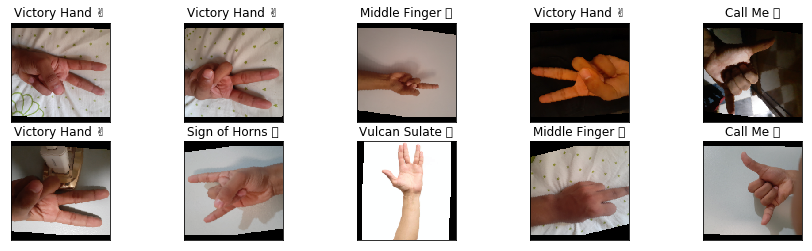

In [15]:
fig = plt.figure(figsize=(15, 4))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    plt.title(cat[labels[idx].item()]+' '+emoji.emojize(Emo[labels[idx].item()]))

In [16]:
model=models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = True
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:02<00:00, 50403871.86it/s]


cuda


In [0]:
fc_inputs = model.fc.in_features
 
model.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.7),
    nn.Linear(256, 7), 
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)

In [0]:
criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.parameters(), lr=0.0003)

model.to(device);

In [19]:
epochs=30
valid_loss_min = np.Inf
validlosses,trainlosses=[],[]
validacc,trainacc=[],[]

for epoch in range(epochs):
  print("Epoch: {}/{} ........".format(epoch+1, epochs))
  
  start = time.time()
 
  
  steps=0
  running_loss=0.0
  accuracy_train=0.0
  
  steps2=0
  valid_loss = 0
  accuracy_valid = 0
    
  model.train()
  
  
  for inputs, labels in trainloader:
    
    steps += 1
    # Move input and label tensors to the default device
    inputs, labels = inputs.to(device), labels.to(device)
        
    optimizer.zero_grad()
        
    logps = model(inputs)
    loss = criterion(logps, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()*inputs.size(0)
    
    ret, predictions = torch.max(logps.data, 1)
    correct_counts = predictions.eq(labels.data.view_as(predictions))
    # Convert correct_counts to float and then compute the mean
    acc = torch.mean(correct_counts.type(torch.FloatTensor))
         
    # Compute total accuracy in the whole batch and add to train_acc
    accuracy_train += acc.item() * inputs.size(0)
    print("Training Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(steps, loss.item(), acc.item()))
    
  else:
   
    with torch.no_grad():
      model.eval()
      for inputs, labels in validloader:
        steps2+=1
        inputs, labels = inputs.to(device), labels.to(device)
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
                    
        valid_loss += loss.item()
        # Calculate validation accuracy
        ret, predictions = torch.max(logps.data, 1)
        correct_counts = predictions.eq(labels.data.view_as(predictions))
 
        # Convert correct_counts to float and then compute the mean
        acc = torch.mean(correct_counts.type(torch.FloatTensor))
        
 
        # Compute total accuracy in the whole batch and add to valid_acc
        accuracy_valid += acc.item() * inputs.size(0)
        print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(steps2, loss.item(), acc.item()))
    
    
  # Find average training loss and training accuracy
  avg_train_loss = running_loss/train_size 
  avg_train_acc = accuracy_train/float(train_size)
 
  # Find average training loss and training accuracy
  avg_valid_loss = valid_loss/valid_size 
  avg_valid_acc = accuracy_valid/float(valid_size)


  trainacc.append(avg_train_acc)
  validacc.append(avg_valid_acc)
  trainlosses.append(avg_train_loss)
  validlosses.append(avg_valid_loss)
  stop = time.time()

  end = time.time()
 
  print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch+1, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, end-start))
    
    
  if avg_valid_loss <= valid_loss_min:
      
      print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
          valid_loss_min,
          avg_valid_loss))
      torch.save(model.state_dict(), 'model_emoji.pt')
      valid_loss_min = avg_valid_loss


Epoch: 1/30 ........
Training Batch number: 001, Training: Loss: 1.9404, Accuracy: 0.1875
Training Batch number: 002, Training: Loss: 1.9231, Accuracy: 0.1250
Training Batch number: 003, Training: Loss: 1.9196, Accuracy: 0.3750
Training Batch number: 004, Training: Loss: 1.9433, Accuracy: 0.1875
Training Batch number: 005, Training: Loss: 1.8062, Accuracy: 0.1875
Training Batch number: 006, Training: Loss: 1.8089, Accuracy: 0.2188
Training Batch number: 007, Training: Loss: 1.6820, Accuracy: 0.3750
Training Batch number: 008, Training: Loss: 1.7023, Accuracy: 0.2812
Training Batch number: 009, Training: Loss: 1.5795, Accuracy: 0.4688
Training Batch number: 010, Training: Loss: 1.5821, Accuracy: 0.5000
Training Batch number: 011, Training: Loss: 1.3622, Accuracy: 0.5000
Training Batch number: 012, Training: Loss: 1.2766, Accuracy: 0.7500
Training Batch number: 013, Training: Loss: 1.1227, Accuracy: 0.7500
Training Batch number: 014, Training: Loss: 1.1962, Accuracy: 0.6562
Training Batc

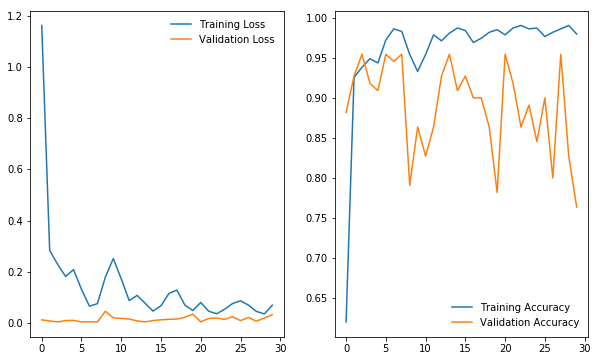

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
ax1.plot(trainlosses,label='Training Loss')
ax1.plot(validlosses,label='Validation Loss')

ax1.legend(frameon=False)

ax2.plot(trainacc,label='Training Accuracy')
ax2.plot(validacc,label='Validation Accuracy')

ax2.legend(frameon=False)

In [21]:
model.load_state_dict(torch.load('model_emoji.pt'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [41]:
train_on_GPU=True
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(7))
class_total = list(0. for i in range(7))

model.eval()
# iterate over test data
for data, target in testloader:
    # move tensors to GPU if CUDA is available
    data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_GPU else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(testloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(7):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            cat[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.012224

Test Accuracy of Call Me: 100% (14/14)
Test Accuracy of Forced Hand: 100% ( 5/ 5)
Test Accuracy of Middle Finger: 100% (10/10)
Test Accuracy of Raised Hand: 100% ( 7/ 7)
Test Accuracy of Sign of Horns: 100% ( 7/ 7)
Test Accuracy of Victory Hand: 100% ( 5/ 5)
Test Accuracy of Vulcan Sulate: 100% ( 8/ 8)

Test Accuracy (Overall): 100% (56/56)


In [0]:
img=Image.open("/content/drive/My Drive/Test/A.jpg")

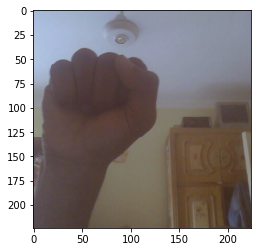

In [45]:
img=test_transforms(img)

imgshow=im_convert(img)
plt.imshow(imgshow)


Output class :  Forced Hand ✊


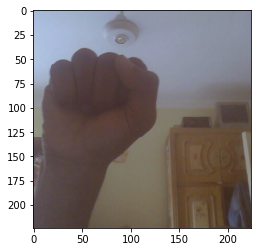

In [49]:
img=img.view(1, 3, 224, 224).cuda()
with torch.no_grad():
  
  model.eval()
  # Model outputs log probabilities
  out = model(img)
  ps = torch.exp(out)
  topk, topclass = ps.topk(1, dim=1)
  pri="Output class :  "+ cat[topclass.cpu().numpy()[0][0]]+' '+emoji.emojize(str(Emo[topclass.cpu().numpy()[0][0]]))
  print(pri)
plt.imshow(imgshow)

## Video Cam

In [0]:


VIDEO_HTML = """
<video autoplay
 width=%d height=%d style='cursor: pointer;'></video>
<script>

var video = document.querySelector('video')

navigator.mediaDevices.getUserMedia({ video: true })
  .then(stream=> video.srcObject = stream)
  
var data = new Promise(resolve=>{
  video.onclick = ()=>{
    var canvas = document.createElement('canvas')
    var [w,h] = [video.offsetWidth, video.offsetHeight]
    canvas.width = w
    canvas.height = h
    canvas.getContext('2d')
          .drawImage(video, 0, 0, w, h)
    video.srcObject.getVideoTracks()[0].stop()
    video.replaceWith(canvas)
    resolve(canvas.toDataURL('image/jpeg', %f))
  }
})
</script>
"""
def take_photo(filename='photo.jpg', quality=0.8, size=(800,600)):
  display(HTML(VIDEO_HTML % (size[0],size[1],quality)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  f = io.BytesIO(binary)
  return np.asarray(Image.open(f))
#   with open(filename, 'wb') as f:
#     f.write(binary)
#   return len(binary)

In [62]:
while True:
  model.eval()
  imgv = take_photo()
  pilimg = Image.fromarray(imgv)
  imgv=test_transforms(pilimg)
  imgv=imgv.view(1, 3, 224, 224).cuda()
  with torch.no_grad():
        
    out = model(imgv)
    ps = torch.exp(out)
    topk, topclass = ps.topk(1, dim=1)
    pri=cat[topclass.cpu().numpy()[0][0]]+' '+emoji.emojize(str(Emo[topclass.cpu().numpy()[0][0]]))
  if(topk.item()*100.0)<60.0:
    print("Not Detect Emoji Correct")
  else:
    print("Get Accuracy {} Of {}".format(topk.item()*100.0,pri))
  print("Again??")
  again=True
  while again:
    inp=input()
    if(inp=="no"):
      again=False
      break
    elif inp=="yes":
      again=False
      continue
    else:
      print("Again! Write Command Correct, yes or no?")
  if inp=="no" and not again:
    break;

Get Accuracy 99.08359050750732 Of Forced Hand ✊
Again??
no
